# Indonesian Sentiment Classification with IndoBERT
This notebook fine‑tunes **[`indobenchmark/indobert-base-p1`](https://huggingface.co/indobenchmark/indobert-base-p1)** on an Indonesian Instagram‑comment sentiment dataset.

**Pipeline outline**
1. Install and import dependencies
2. Load the dataset
3. Exploratory data analysis (EDA)
4. Pre‑processing & tokenization
5. Fine‑tune IndoBERT
6. Evaluation (accuracy, precision, recall, F1, confusion matrix)
7. Error analysis & discussion of Indonesian‑specific challenges

> **Tip:** Run the notebook in a GPU‑enabled runtime (e.g. Colab) for reasonable training speed.

In [2]:
!pip -q install transformers datasets evaluate accelerate scikit-learn matplotlib seaborn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset, ClassLabel
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
import evaluate
import torch, random, os, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)


## 1. Load dataset

In [3]:
DATA_URL = "https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_komentar_instagram_cyberbullying.csv"
df = pd.read_csv(DATA_URL)
print(df.head())
print("\nShape:", df.shape)


   Id Sentiment                             Instagram Comment Text
0   1  negative   <USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1   2  negative  Geblek lo tata...cowo bgt dibela2in balikan......
2   3  negative  Kmrn termewek2 skr lengket lg duhhh kok labil ...
3   4  negative  Intinya kalau kesel dengan ATT nya, gausah ke ...
4   5  negative  hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...

Shape: (400, 3)


### Label distribution

label
negative    200
positive    200
Name: count, dtype: int64


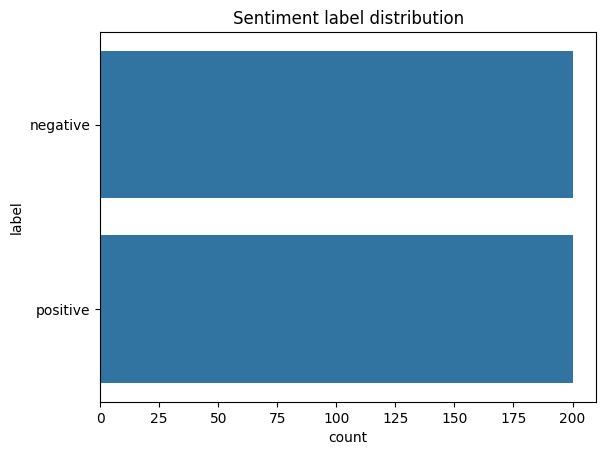

In [4]:
label_col = "Sentiment" if "Sentiment" in df.columns else df.columns[1]  # fallback
text_col  = "Instagram Comment Text" if "Instagram Comment Text" in df.columns else df.columns[2]

df = df.rename(columns={label_col: "label", text_col: "text"})
print(df['label'].value_counts())
sns.countplot(y="label", data=df)
plt.title("Sentiment label distribution")
plt.show()


In [5]:
label_list = sorted(df.label.unique())
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}
df['label'] = df['label'].map(label2id)
num_labels = len(label_list)
print("Label mapping:", label2id)


Label mapping: {'negative': 0, 'positive': 1}


## 2. Train / validation split

In [6]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)

train_ds = Dataset.from_pandas(train_df)
test_ds  = Dataset.from_pandas(test_df)

print(train_ds, test_ds)


Dataset({
    features: ['Id', 'label', 'text', '__index_level_0__'],
    num_rows: 320
}) Dataset({
    features: ['Id', 'label', 'text', '__index_level_0__'],
    num_rows: 80
})


## 3. Tokenization

In [7]:
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_ds.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_test  = test_ds.map(tokenize_function, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_train = tokenized_train.rename_column("label","labels")
tokenized_test  = tokenized_test.rename_column("label","labels")
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

## 4. Load IndoBERT for classification

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
accuracy_metric  = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric    = evaluate.load("recall")
f1_metric        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc  = accuracy_metric.compute(predictions=preds, references=labels)
    prec = precision_metric.compute(predictions=preds, references=labels, average="weighted")
    rec  = recall_metric.compute(predictions=preds, references=labels, average="weighted")
    f1   = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return {"accuracy": acc["accuracy"],
            "precision": prec["precision"],
            "recall": rec["recall"],
            "f1": f1["f1"]}


## 5. Fine‑tune

In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()


<ipython-input-10-b74f39a2af94>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: brian-sangapta (brian-sangapta-binus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.293461,0.912500,0.914833,0.912500,0.912377
2,No log,0.237889,0.925000,0.929293,0.925000,0.924812
3,No log,0.182051,0.925000,0.925000,0.925000,0.925000


TrainOutput(global_step=60, training_loss=0.2751159985860189, metrics={'train_runtime': 243.8952, 'train_samples_per_second': 3.936, 'train_steps_per_second': 0.246, 'total_flos': 42566435424960.0, 'train_loss': 0.2751159985860189, 'epoch': 3.0})

## 6. Evaluation

In [11]:
metrics = trainer.evaluate()
print("Final metrics:", metrics)


Final metrics: {'eval_loss': 0.1820507049560547, 'eval_accuracy': 0.925, 'eval_precision': 0.925, 'eval_recall': 0.925, 'eval_f1': 0.925, 'eval_runtime': 0.6053, 'eval_samples_per_second': 132.173, 'eval_steps_per_second': 4.956, 'epoch': 3.0}


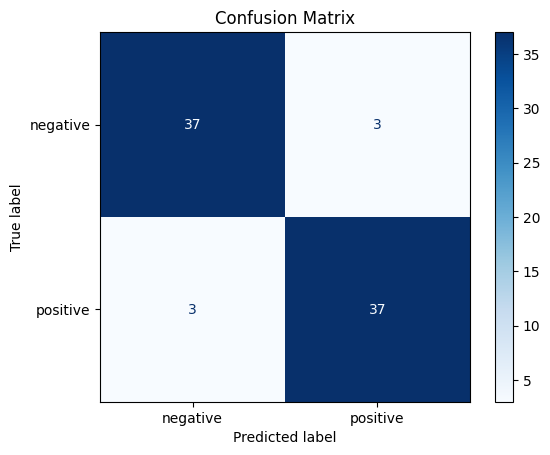

In [12]:
predictions = trainer.predict(tokenized_test)
y_pred = predictions.predictions.argmax(axis=-1)
y_true = predictions.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_list))

              precision    recall  f1-score   support

    negative       0.93      0.93      0.93        40
    positive       0.93      0.93      0.93        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.93        80
weighted avg       0.93      0.93      0.93        80



## 7. Error analysis

In [14]:
err_df = test_df.copy()
err_df['pred_label'] = y_pred

# filter yang salah klasifikasi
mask = err_df['label'] != err_df['pred_label']
miscls = err_df[mask]

# hitung berapa yang tersedia, ambil minimal antara 10 atau total miscls
n = min(10, len(miscls))
samples = miscls.sample(n, random_state=SEED)

# mapping label ke nama
samples = samples.assign(
    true_label = samples['label'].map(id2label),
    pred_label = samples['pred_label'].map(id2label)
)

# tampilkan kolom yang diinginkan
samples[['text', 'true_label', 'pred_label']]


,text,true_label,pred_label
251,Gagah kali abang borisq ini.. Klo gk bc nmx bn...,positive,negative
50,Alah laki laki jaman skrg sm aja. Sama sama be...,negative,positive
74,<USERNAME> yutub apaan ya mba? Aplikasi baru ...,negative,positive
121,Semoga pelakor2 kena karma dan semoga dapat ka...,negative,positive
346,Hatinya terbuat dari apa ya .. Mbaa gigi yang ...,positive,negative
292,"Kasian anaknya,, jgn sampek anaknya rusak juga...",positive,negative


### Discussion: common error patterns & Indonesian‑specific challenges
* **Informal slang & abbreviations** – e.g., *'bgt'*, *'gk'*, *'gue'*, which diverge from standard Indonesian and may not be well‑represented in IndoBERT pre‑training.
* **Code‑mixing with English/Javanese/Sundanese** – mixed language tokens can confuse the model.
* **Sarcasm & irony** – literal sentiment words may appear positive although the overall meaning is negative and vice‑versa.
* **Repetition & elongation** – e.g., *'sakittttt'*, *'bagus bangettt'*, introducing out‑of‑vocab tokens.
* **Profanity variations** – creative spellings of offensive words to evade moderation.

Potential mitigations:
- Expand training data with more informal texts (social media, forums).
- Utilize a tokenizer with byte‑level BPE (e.g., IndoBERTweet) or apply additional domain‑specific pre‑training.
- Data augmentation for sarcasm detection or use models incorporating context beyond single comments.